# Equations of Motion

There are two connected problems at the foundation of electricity and magnetism:

1. Given the locations and trajectories of all of the charges in a system, use **Maxwell's Equations** to compute the fields.
2. Given the electric and magnetic fieldds in a system, use the **Lorentz force law** to compute the trajectories of the charges.

In electrodynamics, we have to solve both problems together, updating the fields and the motion of the charges simultaneously.  In electrostatics, we treat each problem separately.

In this notebook, we will explore ***numerical methods*** for studying the motion of charges, given the electric and magnetic fields.  In the next one, we will introduce the ***finite element method*** to compute the electric field given a charge distribution.  (Next week, we will compute magnetic fields, too!)

## Finite Differences

The "Dynamic Loop" can be used to compute the motion of a system of particles.  We use Newton's Second Law to repeatedly update the positions and velocities of each particle.

1. Compute the forces.
2. Update the velocities.
3. Update the positions.
4. Go to 1.

There are more efficient ways to do the numerical integration, but for simplicity, we will start with first-order finite differences.  In essence, we make the approximation

$$\dfrac{df}{dt} \approx \dfrac{f_{n+1} - f_n}{\Delta t}$$

and use this to determine the next value of $f$ from the current value and the derivative:

$$f_{n+1} \approx f_n + \Delta t \cdot \dfrac{df}{dt}$$

This method assumes that the derivative $\dfrac{df}{dt}$ can be calculated.

### Constant Acceleration

Let's apply this method to a system whose solution is known: one-dimensional motion under constant acceleration.

The equations of motion are

$$\dfrac{dx}{dt} = v(t) \qquad \qquad \dfrac{dv}{dt} = a$$

Let the (constant) acceleration be the acceleration due to gravity and use the following values for the initial position and velocity.  (You can experiment with other values later.)

$$a=-9.8 \ {\tt m/s^2} \qquad \qquad x_0 = 0.0 \ {\tt m} \qquad \qquad v_0 = 98 \ {\tt m/s}$$

The Python code below will simulate the motion of the projectile for 20 seconds.

In [1]:
# Get access to useful functions.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.integrate import odeint

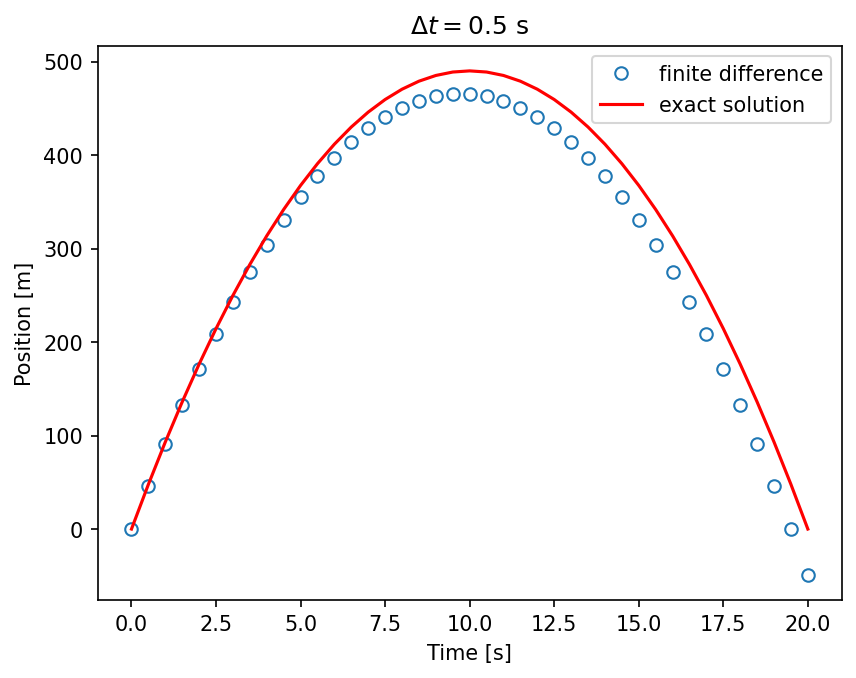

In [8]:
# Define parameters of problem.  All quantities are in SI units.
acceleration = -9.8
initial_position = 0.0
initial_velocity = 98.0
dt = .5
t_max = 20

# Create arrays for time, position, and velocity.
t = np.arange(0, t_max+dt, dt)
num_steps = len(t)
x = np.zeros(num_steps)
v = np.zeros(num_steps)

# Set initial position and velocity.
x[0] = initial_position
v[0] = initial_velocity

# Loop over time values and update position and velocity.
# Start at 1, because x[0] and v[0] are already defined.
for n in range(1,num_steps):
    # Update velocity.
    v[n] = v[n-1] + acceleration * dt

    # Update position.
    x[n] = x[n-1] + v[n] * dt

# Compare the finite difference result to the analytic result.
x_exact = initial_position + initial_velocity * t + 0.5 * acceleration * t**2

plt.figure(dpi=150)
plt.plot(t, x, 'o', mfc='white', label="finite difference")
plt.plot(t, x_exact, 'r-', label="exact solution")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.title(r"$\Delta t = %g$ s" % dt)
plt.legend()

Create plots of $x(t)$ to compare the exact solution with the result of the finite difference method for the following values of the time step:

- $\Delta t = 1.0 \ {\tt s}$
- $\Delta t = 0.1 \ {\tt s}$
- $\Delta t = 0.01 \ {\tt s}$
- $\Delta t = 0.001 \ {\tt s}$

Explore other values of $\Delta t$ if you would like.

***Describe your observations.***  
Is there a point beyond which you would say the finite difference method has "converged" to the exact solution?

***Replace with your comments.***

## Coulomb Scattering

Let's look at a two-dimensional problem from electricity and magnetism now: Coulomb scattering.  (An analysis of this problem is what led Rutherford to conclude that atomic nuclei occupy a tiny volume within an atom.)

Two charged particles interact by the Coulomb force between them.
$$\vec{F}(\vec{r}) = \dfrac{qQ}{r^2} \, \hat{e}_r = qQ \, \dfrac{\vec{r}}{r^3}$$

Both charged particles experience a force, but we will assume that one particle has a much greater mass than the other so that we can ignore its acceleration.  We will assume the large particle sits at the origin, so that $\vec{r}$ is the separation of the two particles _and_ the location of the smaller particle.  (This is a decent approximation for $\alpha$-particles scattering off of gold nuclei, as in Rutherford's experiments: $m/M = 4/197 \approx 1/50$.  The acceleration of the helium nucleus is 50 times larger than the gold nucleus.)

Our equations of motion for the helium nucleus are
$$
\dfrac{d\vec{r}}{dt} = \vec{v}
\qquad \qquad
\dfrac{d\vec{v}}{dt} = \vec{a} = \dfrac{\vec{F}}{m} = \dfrac{qQ}{m} \, \dfrac{\vec{r}}{r^3}
$$

It is possible to solve the equations of motion for Coulomb scattering analytically.  However, we can also specify the initial conditions, integrate the equations of motion, and compute the trajectory with a `for` loop.

The following function will compute the trajectory of a charged particle given its initial speed $v_0$ — assumed to be in the $z$-direction — and its ***impact parameter*** — its initial displacement to the left or right of the massive particle at the origin.

In [31]:
def get_trajectory(b, v0, q=+1, Q=+1, L=5, dt=2e-4, N=1e6):
    """
    Integrate the equations of motion for Coulomb's law to generate a scattering
    trajectory.

        v0 = initial speed of particle
        b  = impact parameter of trajectory
        q  = charge of light particle
        Q  = charge of massive particle
        L  = box size
        dt = time step
        N  = maximum number of time steps
        
    Returns x and y coordinate arrays and time array for the trajectory.
    Computation runs for N time steps, or until the particle leaves the box
    --- whichever comes first.
    
    Note: The calculation uses "natural units" for the problem, so only the
    sign of the two particles matters.
    """
    from math import sin, cos, sqrt, pi
    
    n_max = int(N)

    # Store trajectory in an array.
    x = np.zeros(n_max)
    y = np.zeros(n_max)

    # Initial position.
    x0 = b
    y0 = -L
    r0 = sqrt(x0**2 + y0**2)

    # Initial speed.
    vx0 = 0.0
    vy0 = v0

    # Sign of interaction: +1 ==> repulsive, -1 ==> attractive
    sign = q * Q / abs(q*Q)

    # Initial acceleration.
    ax0 = sign * x0/r0**3
    ay0 = sign * y0/r0**3

    # Current position, velocity, and acceleration
    x[0] = x0
    y[0] = y0
    ax = ax0
    ay = ay0

    # Use midpoint method to compute velocity and improve accuracy.
    vx = vx0 + 0.5 * ax * dt
    vy = vy0 + 0.5 * ay * dt


    for n in range(n_max):
        # Exit the loop when the particle exits the box.
        if (abs(x[n]) > L) or (abs(y[n]) > L): break
            
        # Update positions
        x[n+1] = x[n] + vx * dt
        y[n+1] = y[n] + vy * dt
        r = sqrt(x[n+1]**2 + y[n+1]**2)
        
        # Update acceleration.
        ax = sign * x[n+1] / r**3
        ay = sign * y[n+1] / r**3

        # Update velocities
        vx = vx + ax * dt
        vy = vy + ay * dt
    
    return x[:n], y[:n], dt*np.arange(n)

Let's use this function to generate a trajectory.

Text(0.5, 1.0, 'Coulomb Scattering')

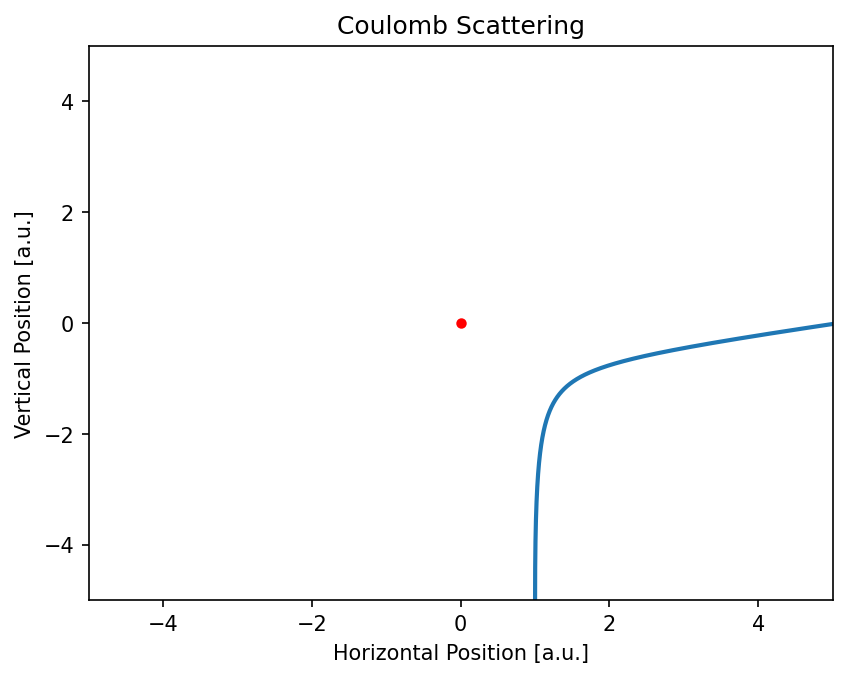

In [39]:
# Generate a trajectories for repulsive interaction.
v0 = 1
b  = 1
q  = +1
Q  = +1
L  = 5

# Create a figure.
plt.figure(dpi=150)

# Generate a trajectory.
x, y, t = get_trajectory(b, v0, q, Q, L)

# Plot it.
plt.plot(x,y, lw=2)

# Add labels and title.
plt.plot(0,0,'ro', ms=4)
plt.axis([-L,L,-L,L])
plt.xlabel('Horizontal Position [a.u.]')
plt.ylabel('Vertical Position [a.u.]')
plt.title('Coulomb Scattering')

Use the cell above to generate several different trajectories.  What patterns do you notice?

***Replace with your comments.***

Repeat the analysis for two charges with opposite signs.  Try changing the initial velocity as well as the impact parameter.

***Describe your observations.***

Rutherford's experiment involved many particles with approximately the same velocity but random impact parameters.  Make a single plot that shows trajectories for 10 different impact parameters (positive and negative) on the same axes.

Try writing a ***for loop***.

Text(0.5, 1.0, 'Coulomb Scattering')

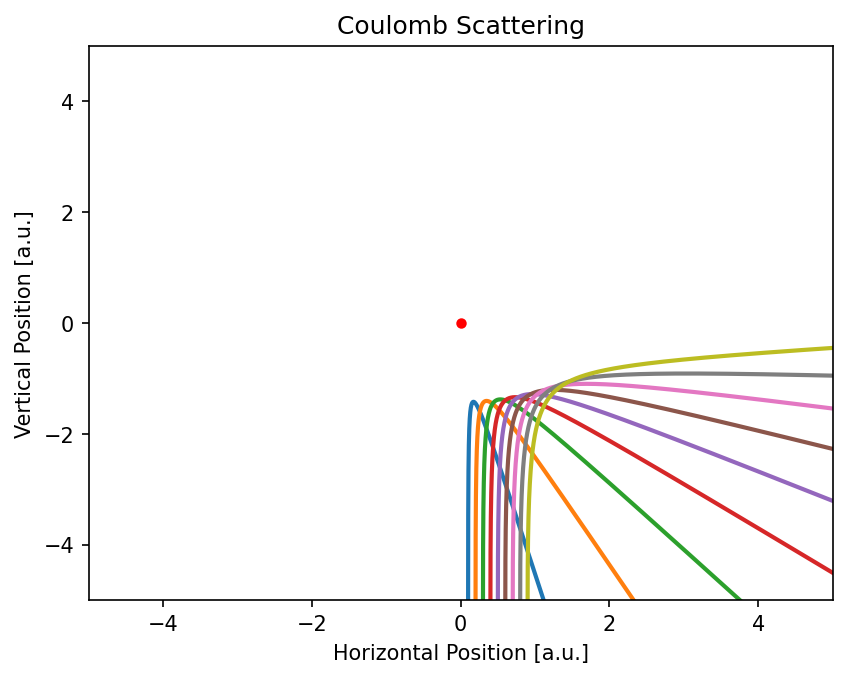

In [52]:
impact = np.arange(0.1,1,.1)
v0 = 1
q  = +1
Q  = +1
L  = 5

plt.figure(dpi=150)

for b in impact:
    x, y, t = get_trajectory(b, v0, q, Q, L)
    plt.plot(x,y, lw=2)

plt.plot(0,0,'ro', ms=4)
plt.axis([-L,L,-L,L])
plt.xlabel('Horizontal Position [a.u.]')
plt.ylabel('Vertical Position [a.u.]')
plt.title('Coulomb Scattering')

## ODEINT

Differential equations that only depend on one parameter, like time, are called ***ordinary differential equations***.  These are are many efficient and accurate algorithms for solving such equations — much better than the "first-order Euler method" we have been using.

In this last exercise, we will explore the Python function `odeint` for solving such equations.  We will use it to solve a three-dimension problem of a charged particle moving in static, uniform electric and magnetic fields.

### Background

We will use the `odeint` function of the `scipy.integrate` module. This function requires that we express our problem in a particular way. In exchange, it will do all of the grunt  ork of numerical integration. It is a deal worth making!

In essence, we have to express our differential equation or system of differential equations as a set of coupled first-order differential equations. Fortunately, this is possible in most cases of practical interest.

For instance, to solve the second-order differential equation for a mass on a spring, we start with

$$\dfrac{d^2 x}{d t^2} = -x.$$

The set of first-order differential equations for this system is
$$
\vec{y} = \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}
\qquad \qquad
\dfrac{ d \vec{y} }{ d t} = \vec{F}(\vec{y}, t) = \begin{bmatrix} y_2 \\
        -y_1 \end{bmatrix}.
$$

We have defined the following variables:
$$ y_1 = x \qquad \qquad y_2 = \dfrac{d y_1}{d t} = \dfrac{d x}{d t}. $$

**Make sure you understand why these are equivalent before you move on!**

See Section 6.8 of _A Student's Guide to Python_ for more details.

The syntax for `odeint` is deceptively simple:

    y = odeint(F, y0, t)

-   `t` is an array of time values where we want the value of `y`.
-   `y0` is an array of initial conditions — one initial condition for
    each variable in our system of differential equations.
-   `F` is a function that takes an array with the shape of `y0` and a
    scalar `t0` and returns an array with the shape of `y0`.

`odeint` will take the time array, the initial conditions, and the
function you provide and integrate solve the differential equation
$$\dfrac{d\vec{y}}{dt} = \vec{F}(\vec{y},t).$$ It will return the values
of $\vec{y}(t)$ at the times specified in the array of time values.

And that’s it!

### Lorentz Force Law

Our goal is to determine the motion of a charged particle in electric and magnetic fields.  Thus, our starting point is the Lorentz force law:
$$\vec{F} = q \left(\vec{E} + \dfrac{\vec{v}}{c} \times \vec{B} \right)$$

In natural units, we can express this as
$$\dfrac{d^2 \vec{r}}{dt} = \vec{E} + \vec{v} \times \vec{B}$$

To use `odeint` we need to recast the problem as a set of coupled first-order differential equations and write a single function to evaluate all of the derivatives.

In [53]:
# Define the derivative function.
def dy_dt(y, t, E, B):
    """
    y = [x, y, z, vx, vy, vz]
    t = time
    E = [Ex, Ey, Ez] is the electric field
    B = [Bx, By, Bz] is the magnetic field
    
    The function returns dy/dt based on the Lorentz force law:
    F = E + vxB.
    """
    dy = np.zeros(6)
    
    # Position derivatives
    dy[0] = y[3]
    dy[1] = y[4]
    dy[2] = y[5]
    
    # Velocity derivatives
    dy[3] = E[0] + (y[4]*B[2] - y[5]*B[1])
    dy[4] = E[1] + (y[5]*B[0] - y[3]*B[2])
    dy[5] = E[2] + (y[3]*B[1] - y[4]*B[0])
    
    # Return the derivative array.
    return dy

Explain why the velocity derivatives are correct.  That is, explain why the Python expressions above give the correct components of the Lorentz force vector.

***Replace with your response.***

Let's use this function with `odeint` to simulate the motion of a charged particle in some practical situations.

### Constant Electric Field

Consider a particle moving with some initial velocity in the $xy$-plane that enters a region of uniform electric field in the $z$ direction.

Predict how the charge will move.

***Replace with your response.***

Use the following cells to explore the scenario.

In [54]:
## Use this command to turn ON interactive plots:
%matplotlib notebook

## Use this command to turn OFF interactive plots.
# %matplotlib inline

In [58]:
# Define electric and magnetic fields.
Ex = 0
Ey = 0
Ez = 1
E = np.array([Ex, Ey, Ez])

Bx = 0
By = 0
Bz = 0
B = np.array([Bx, By, Bz])

# Define array of time values to study.
num_points = 101
tMax = 10
t = np.linspace(0, tMax, num_points)

# Define the initial conditions.
X0 = -5
Y0 = -5
Z0 = 0

VX0 = 2
VY0 = 1
VZ0 = 0

y0 = np.array([X0, Y0, Z0, VX0, VY0, VZ0])

# Integrate the equations of motion.
trajectory = odeint(dy_dt, y0, t, args=(E,B))
x, y, z, vx, vy, vz = trajectory.transpose()

<IPython.core.display.Javascript object>


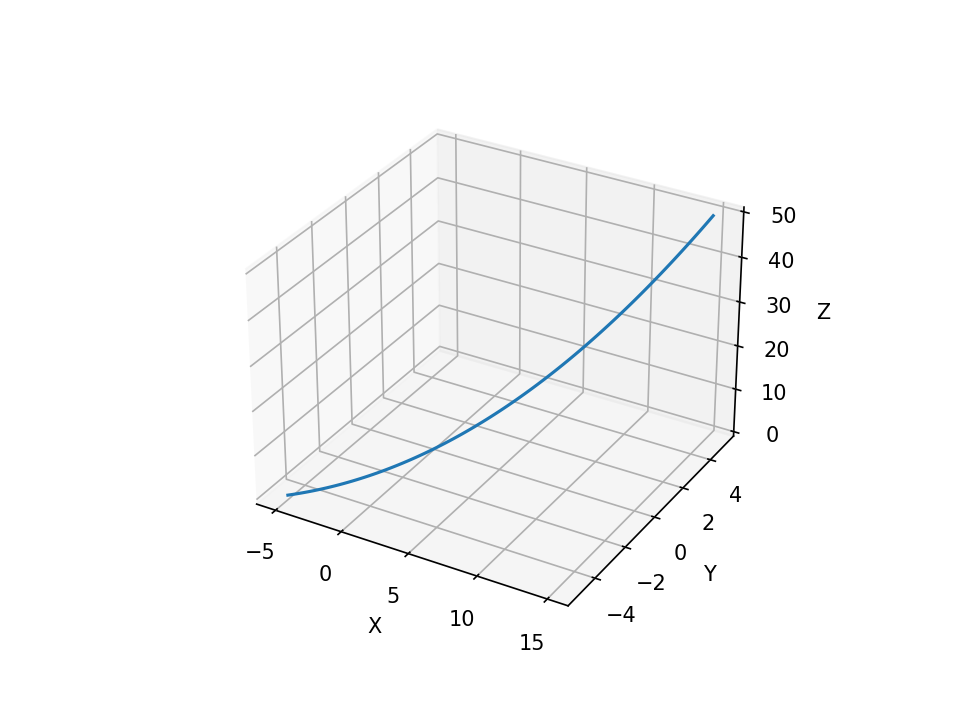

Text(0.5, 0, 'Z')

In [59]:
# Plot the result.
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
ax.plot(x,y,z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

What path does the particle follow?  Try several different sets of initial conditions, and change the duration of the simulation as needed.

Was your prediction for the motion correct?

***Replace with your response.***

### Constant Magnetic Field

Consider a particle initially moving in the $xz$-plane that enters a region of uniform magnetic field pointing along the $z$-axis.

What do you think the trajectory of this particle will look like?

***Replace with your predictions.***

The cells below are a copy of the code from the previous section.  Modify it to simulate the system described above.

In [70]:
# Define electric and magnetic fields.
Ex = 0
Ey = 0
Ez = 0
E = np.array([Ex, Ey, Ez])

Bx = 0
By = 0
Bz = 1
B = np.array([Bx, By, Bz])

# Define array of time values to study.
num_points = 101
tMax = 10
t = np.linspace(0, tMax, num_points)

# Define the initial conditions.
X0 = -5
Y0 = -5
Z0 = 0

VX0 = 2
VY0 = 0
VZ0 = 1

y0 = np.array([X0, Y0, Z0, VX0, VY0, VZ0])

# Integrate the equations of motion.
trajectory = odeint(dy_dt, y0, t, args=(E,B))
x, y, z, vx, vy, vz = trajectory.transpose()

<IPython.core.display.Javascript object>


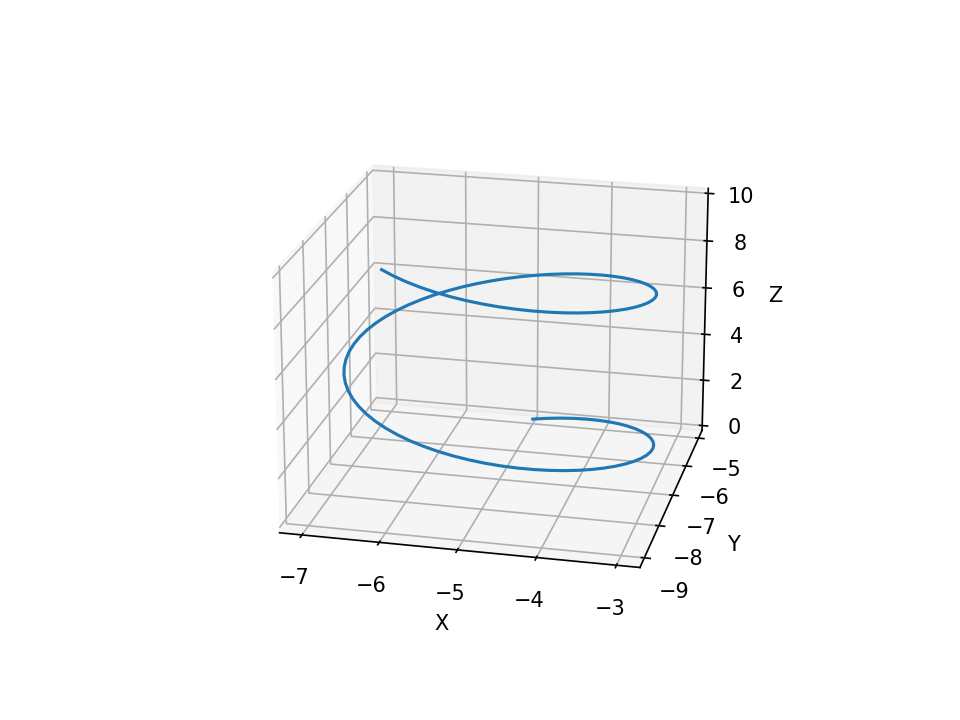

Text(0.5, 0, 'Z')

In [71]:
# Plot the result.
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
ax.plot(x,y,z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Change the strength of the field and the initial conditions to simulate several different trajectories.  Describe your experiments and observations.

***Replace with your observations.***

### Crossed Fields

Now consider the motion of a charged particle in a region of crossed fields: constant electric and magnetic fields that are perpendicular to each other.

What do you think the trajectory of this particle will look like?  
How will it change with the initial velocity (magnitude and direction) of the particle?

***Replace with your predictions.***

Below is yet one more copy of the constant electric field code.  Modify it to simulate the scenario described in Problem 1-31 and Problem 1-32 of Heald & Marion.

In [120]:
# Define electric and magnetic fields.
Ex = 1
Ey = 0
Ez = 0
E = np.array([Ex, Ey, Ez])

Bx = 0
By = 1
Bz = 0
B = np.array([Bx, By, Bz])

# Define array of time values to study.
num_points = 501
tMax = 30
t = np.linspace(0, tMax, num_points)

# Define the initial conditions.
X0 = -5
Y0 = -5
Z0 = 0

VX0 = 3
VY0 = 2
VZ0 = 4

y0 = np.array([X0, Y0, Z0, VX0, VY0, VZ0])

# Integrate the equations of motion.
trajectory = odeint(dy_dt, y0, t, args=(E,B))
x, y, z, vx, vy, vz = trajectory.transpose()

In [123]:
np.mean(vz)

0.9863020139987563

<IPython.core.display.Javascript object>


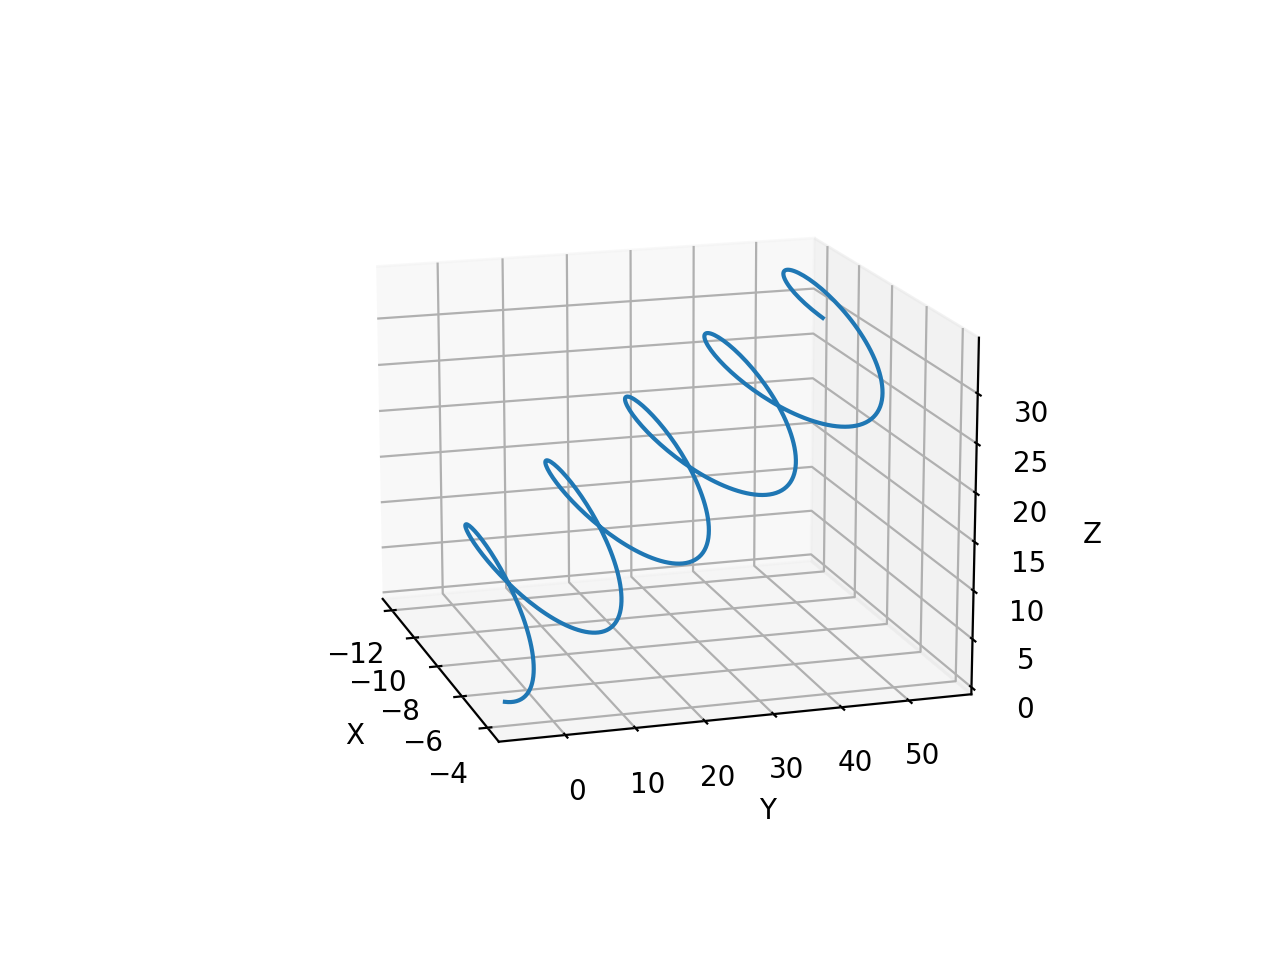

Text(0.5, 0, 'Z')

In [124]:
# Plot the result.
fig = plt.figure(dpi=200)
ax = fig.add_subplot(projection='3d')
ax.plot(x,y,z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Change the strength and direction of the fields and modify the initial conditions to simulate several different trajectories.  Describe your experiments and observations.

***Replace with your observations.***

What happens when you release the particle from rest at the origin in crossed fields?

***Replace with your observations.***

## Reflection and Summary

Congratulations! You just completed a crash course in ordinary differential equations!

- What are the major takeaways of this assignment for you?
- What was the most difficult part of this assignment?
- What was the most interesting part of this assignment?
- What questions do you have?

***Replace with your response.***